In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('df11_new.csv')

In [3]:
data.head()

gender  age     job  marital province  city prefer  frequency  \
0    MALE  50대  중소기업직원  MARREID      부산시  해운대구     당도          5   
1  FEMALE  30대     연구원   SINGLE      경상도   하동군    깊이감          2   
2  FEMALE  30대     자영업  MARREID      부산시   사하구    깊이감          4   
3  FEMALE  40대     자영업  MARREID      부산시   사하구     당도          1   
4  FEMALE  40대      의사  MARREID      서울시   강남구    깊이감          1   

   wineFrequency        side  ... choice1_과일향  choice1_오크향 choice1_깊이  \
0              4       Annon  ...           M            H          H   
1              1   Roquefort  ...           H            M          L   
2              1     Cheddar  ...           H            M          L   
3              1  Gorgonzola  ...           H            M          L   
4              1  Gorgonzola  ...           H            M          M   

  choice1_견고함 choice2_당도 choice2_알콜 농도 choice2_과일향 choice2_오크향 choice2_깊이  \
0           H          M             H           M           H          H   
1           L          H             L           H           M          L   
2           M          L             H           H           H          M   
3           L          H             L           H           M          L   
4           M          H             L           H           M          M   

  choice2_견고함  
0           H  
1           M  
2           M  
3           M  
4           M  

[5 rows x 26 columns]

In [4]:
to_drop = [category for category in data.columns if (category.startswith('choice1_') or (category.startswith('choice2_') or (category == 'seq')))]
data.drop(to_drop, axis = 1, inplace = True)

In [10]:
job_dict = dict()
job_dict['중소기업직원'] = '중급'
job_dict['벤처직원'] = '중급'
job_dict['회사직원'] = '중급'
job_dict['연구원'] = '고급'
job_dict['의사'] = '고급'
job_dict['변호사'] = '고급'
job_dict['교수'] = '고급'
job_dict['기자'] = '고급'
job_dict['자영업'] = '프리'
job_dict['임시직'] = '프리'
job_dict['학생'] = '학생'
job_dict['공무원'] = '갓'

data['job_group'] = data['job'].apply((lambda x:job_dict[x]))
data.drop('job', axis = 1, inplace = True)


In [153]:
data.head()

gender  age  marital job_group choice1
0    MALE  50대  MARREID        중급       A
1  FEMALE  30대   SINGLE        고급       D
2  FEMALE  30대  MARREID        프리       B
3  FEMALE  40대  MARREID        프리       D
4  FEMALE  40대  MARREID        고급       C

In [ ]:
data.groupby(['age', 'gender']).sum()

In [12]:
data.head()
# data = data[['gender', 'age', 'marital', 'job_group', 'choice1', 'area_grade']]

data = data[['gender', 'age', 'marital', 'job_group', 'choice1']]

In [13]:
df_list = list()
for choice in sorted(data['choice1'].unique()):
    df_list.append(data[data['choice1'] == choice])

In [14]:
tmp = pd.concat(df_list[1:])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp.head()

gender  age  marital job_group choice1
0    MALE  30대  MARREID        중급       F
1  FEMALE  20대  MARREID        학생       B
2    MALE  20대  MARREID        중급       B
3  FEMALE  20대   SINGLE        학생       B
4  FEMALE  30대   SINGLE        중급       E

In [15]:
tmp['choice1'] = 0

In [23]:
dfa = df_list[0].copy()
dfa['choice1'] = 1
tmp = tmp.loc[:len(dfa.index)-1, :]

In [24]:
print(len(dfa), len(tmp))

822 822


In [26]:
dfa_train, dfa_test, tmp_train, tmp_test = train_test_split(dfa, tmp, test_size = 0.3, random_state = 777)

qq_train = pd.concat([dfa_train, tmp_train])
qq_test = pd.concat([dfa_test, tmp_test])

In [31]:
qq_train_y = qq_train['choice1']
qq_train_x = qq_train.drop('choice1', inplace = False, axis = 1)
qq_test_x = qq_test.drop('choice1', axis = 1, inplace = False)
qq_test_y = qq_test['choice1']

In [33]:
qq_train_x = pd.get_dummies(qq_train_x)
qq_test_x = pd.get_dummies(qq_test_x)

In [34]:
# df_x = pd.get_dummies(dfa.drop('choice1', axis = 1, inplace = False))
# df_y = dfa[['choice1']]

tree = DecisionTreeClassifier(random_state=777)
tree.fit(qq_train_x, qq_train_y)
print(classification_report(qq_test_y, tree.predict(qq_test_x)))

              precision    recall  f1-score   support

           0       0.68      0.82      0.74       247
           1       0.77      0.61      0.68       247

   micro avg       0.71      0.71      0.71       494
   macro avg       0.72      0.71      0.71       494
weighted avg       0.72      0.71      0.71       494



In [36]:
confusion_matrix(qq_test_y, tree.predict(qq_test_x))

array([[202,  45],
       [ 97, 150]])

In [35]:
from sklearn.metrics import confusion_matrix

In [11]:
from sklearn.model_selection import GridSearchCV

estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(qq_train_x, qq_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')

grid_dt.score(df_test_x, df_test_y)

tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=12, random_state=777)
tree.fit(df_train_x, df_train_y)
tree.score(df_test_x, df_test_y)

In [15]:
from sklearn.tree import export_graphviz

In [16]:
import graphviz

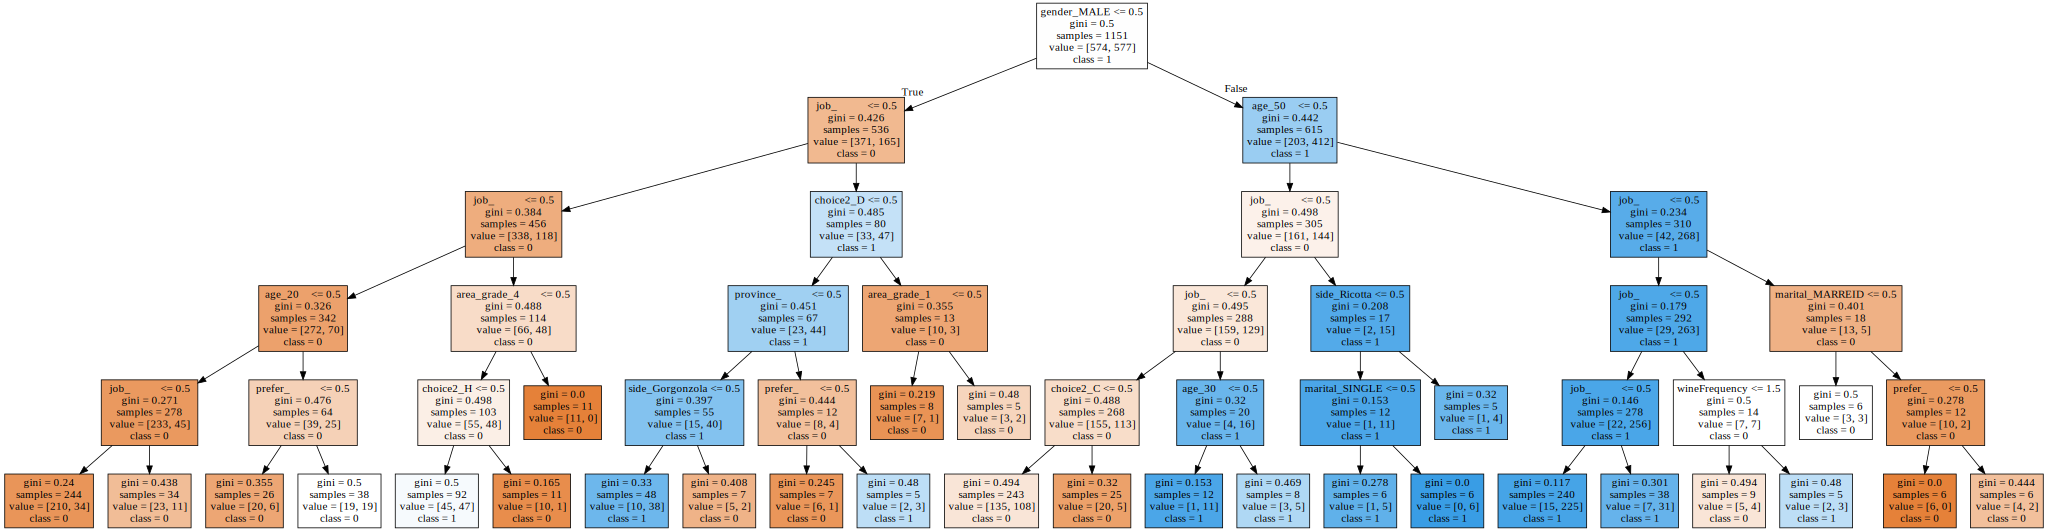

In [17]:
export_graphviz(tree, out_file='dfa.dot', class_names=list(map(str, df_train_y['choice1'].unique())), feature_names = df_train_x.columns, impurity = True, filled = True)
with open('dfa.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 이건 하지말자

In [19]:
dfa = df_list[0].copy()
dfa['choice1'] = 1
tmp = tmp.loc[:len(dfa.index), :]
dfa = pd.concat([dfa, tmp])
dfa.head()

df_x = pd.get_dummies(dfa.loc[:, ['gender', 'age', 'marital']])
df_y = dfa[['choice1']]
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)
tree = DecisionTreeClassifier(random_state=777)
tree.fit(df_train_x, df_train_y)
tree.score(df_test_x, df_test_y)

estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
best parameter:
{'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 2}
best score:
0.676


In [20]:
tree = DecisionTreeClassifier(max_depth=2, min_samples_leaf=5, min_samples_split=2, random_state=777)
tree.fit(df_train_x, df_train_y)
tree.score(df_test_x, df_test_y)
export_graphviz(tree, out_file='dfa_.dot', class_names=list(map(str, df_train_y['choice1'].unique())), feature_names = df_train_x.columns, impurity = True, filled = True)
with open('dfa_.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [114]:
tmp = pd.concat([df_list[5], df_list[1],df_list[2],df_list[4],df_list[3],df_list[6],df_list[7]])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp['choice1'] = 0

In [115]:
dfa = df_list[0].copy()
dfa['choice1'] = 1
try: tmp = tmp.loc[:len(dfa.index)-1, :]
except: tmp = tmp.loc[:len(dfa.index), :]
# dfa = pd.concat([dfa, tmp])

# df_x = pd.get_dummies(dfa.loc[:, ['gender', 'age', 'job_group', 'marital']])
# df_y = dfa[['choice1']]
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

dfa_train, dfa_test, tmp_train, tmp_test = train_test_split(dfa, tmp, test_size = 0.3)

dfa_train = pd.concat([dfa_train, tmp_train])
dfa_test = pd.concat([dfa_test, tmp_test])

dfa_train_x = pd.get_dummies(dfa_train.drop('choice1', axis = 1, inplace = False))
dfa_test_x = pd.get_dummies(dfa_test.drop('choice1', axis = 1, inplace = False))
dfa_train_y = dfa_train['choice1']
dfa_test_y = dfa_test['choice1']


estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(dfa_train_x, dfa_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')
print(classification_report(dfa_test_y, grid_dt.predict(dfa_test_x)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
best parameter:
{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}
best score:
0.718
              precision    recall  f1-score   support

           0       0.64      0.76      0.70       247
           1       0.70      0.58      0.64       247

   micro avg       0.67      0.67      0.67       494
   macro avg       0.67      0.67      0.67       494
weighted avg       0.67      0.67      0.67       494



In [140]:
dfa.groupby(['gender', 'age', 'job_group']).sum()

choice1
gender age    job_group         
FEMALE 20대    갓                4
              고급              10
              중급               9
              프리              37
              학생              10
       30대    갓                6
              고급              11
              중급               4
              프리              33
       40대    갓                8
              고급               7
              중급              13
              프리              38
       50대    갓                3
              고급               3
              중급               4
              프리              30
MALE   20대    갓                1
              고급               8
              중급               4
              프리              23
              학생               7
       30대    갓                5
              고급              24
              중급              10
              프리              25
       40대    갓                7
              고급              40
              중급              18
              프리              28
       50대    갓               47
              고급             155
              중급             162
              프리              17
       60대 이상 갓                1
              고급               5
              중급               5

In [116]:
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf = 5, min_samples_split=20, random_state=777)
tree.fit(dfa_train_x, dfa_train_y)
tree.score(dfa_test_x, dfa_test_y)
export_graphviz(tree, out_file='dfa_.dot', class_names=list(map(str, dfa_train_y.unique())), feature_names = dfa_train_x.columns, impurity = True, filled = True)
with open('dfa_.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [38]:
tmp = pd.concat([df_list[0], df_list[1],df_list[2],df_list[4],df_list[3],df_list[6],df_list[7]])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp['choice1'] = 0

In [39]:
tmp.head()

gender  age  marital job_group  choice1
0  FEMALE  30대   SINGLE        중급        0
1  FEMALE  20대  MARREID        프리        0
2    MALE  50대  MARREID        고급        0
3  FEMALE  50대   SINGLE        프리        0
4  FEMALE  20대   SINGLE        고급        0

In [41]:
from sklearn.model_selection import GridSearchCV

In [43]:
dff = df_list[5].copy()
dff['choice1'] = 1
try: tmp = tmp.loc[:len(dff.index)-1, :]
except: tmp = tmp.loc[:len(dff.index), :]
# dff = pd.concat([dff, tmp])

# df_x = pd.get_dummies(dff.loc[:, ['gender', 'age', 'job_group', 'marital']])
# df_y = dff[['choice1']]
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

dff_train, dff_test, tmp_train, tmp_test = train_test_split(dff, tmp, test_size = 0.3)

dff_train = pd.concat([dff_train, tmp_train])
dff_test = pd.concat([dff_test, tmp_test])

dff_train_x = pd.get_dummies(dff_train.drop('choice1', axis = 1, inplace = False))
dff_test_x = pd.get_dummies(dff_test.drop('choice1', axis = 1, inplace = False))
dff_train_y = dff_train['choice1']
dff_test_y = dff_test['choice1']


estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(dff_train_x, dff_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')
print(classification_report(dff_test_y, grid_dt.predict(dff_test_x)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
best parameter:
{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 20}
best score:
0.692
              precision    recall  f1-score   support

           0       0.63      0.82      0.71       277
           1       0.74      0.52      0.61       277

   micro avg       0.67      0.67      0.67       554
   macro avg       0.68      0.67      0.66       554
weighted avg       0.68      0.67      0.66       554



In [44]:
confusion_matrix(dff_test_y, grid_dt.predict(dff_test_x))

array([[226,  51],
       [133, 144]])

In [46]:
from sklearn.tree import export_graphviz

In [51]:
import graphviz

In [147]:
dff.groupby('gender').sum()

choice1
gender         
FEMALE      302
MALE        619

In [143]:
dff.groupby(['gender', 'marital', 'age']).sum()

choice1
gender marital age            
FEMALE MARREID 20대          46
               30대          40
               40대          71
               50대          49
               60대 이상        2
       SINGLE  20대          19
               30대          22
               40대          32
               50대          21
MALE   MARREID 20대          39
               30대         125
               40대         328
               50대          31
       SINGLE  20대          26
               30대          25
               40대          29
               50대          15
               60대 이상        1

In [152]:
dfa_train_x.loc[1261]

gender_FEMALE      0
gender_MALE        1
age_20대            0
age_30대            0
age_40대            0
age_50대            1
age_60대 이상         0
marital_MARREID    1
marital_SINGLE     0
job_group_갓        0
job_group_고급       0
job_group_중급       1
job_group_프리       0
job_group_학생       0
Name: 1261, dtype: uint8

In [151]:
dfa_train_x.loc[1261].to_numpy()

array([0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0], dtype=uint8)

In [141]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf = 5, min_samples_split=20, random_state=777)
tree.fit(dff_train_x, dff_train_y)
tree.score(dff_test_x, dff_test_y)
export_graphviz(tree, out_file='dff_.dot', class_names=('0', '1'), feature_names = dff_train_x.columns, impurity = True, filled = True)
with open('dff_.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [53]:
tmp = pd.concat([df_list[0], df_list[2],df_list[3],df_list[4],df_list[5],df_list[6],df_list[1]])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp['choice1'] = 0

In [54]:
dfh = df_list[7].copy()
dfh['choice1'] = 1
try: tmp = tmp.loc[:len(dfh.index)-1, :]
except: tmp = tmp.loc[:len(dfh.index)-1, :]

In [57]:
dfh_train, dfh_test, tmp_train, tmp_test = train_test_split(dfh, tmp, test_size = 0.3)
dfh_train = pd.concat([dfh_train, tmp_train])
dfh_test = pd.concat([dfh_test, tmp_test])

dfh_train_x = dfh_train.drop('choice1', axis = 1, inplace = False)
dfh_test_x = dfh_test.drop('choice1', axis = 1, inplace = False)
dfh_train_y = dfh_train['choice1']
dfh_test_y = dfh_test['choice1']

dfh_train_x = pd.get_dummies(dfh_train_x)
dfh_test_x = pd.get_dummies(dfh_test_x)

# dfh = df_list[7].copy()
# dfh['choice1'] = 1
# try: tmp = tmp.loc[:len(dfh.index)-1, :]
# except: tmp = tmp.loc[:len(dfh.index)-1, :]
    
# dfh = pd.concat([dfh, tmp])

# df_x = pd.get_dummies(dfh.loc[:, ['gender', 'age', 'marital']])
# df_y = dfh[['choice1']]
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(dfh_train_x, dfh_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')
print(classification_report(dfh_test_y, grid_dt.predict(dfh_test_x)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=19, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
best parameter:
{'max_depth': 4, 'min_samples_leaf': 19, 'min_samples_split': 2}
best score:
0.66
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       338
           1       0.69      0.76      0.72       338

   micro avg       0.71      0.71      0.71       676
   macro avg       0.71      0.71      0.71       676
weighted avg       0.71      0.71      0.71       676



In [58]:
confusion_matrix(dfh_test_y, grid_dt.predict(dfh_test_x))

array([[223, 115],
       [ 81, 257]])

In [58]:
grid_dt.predict([df_test_x.loc[2084].to_numpy()])

array([0])

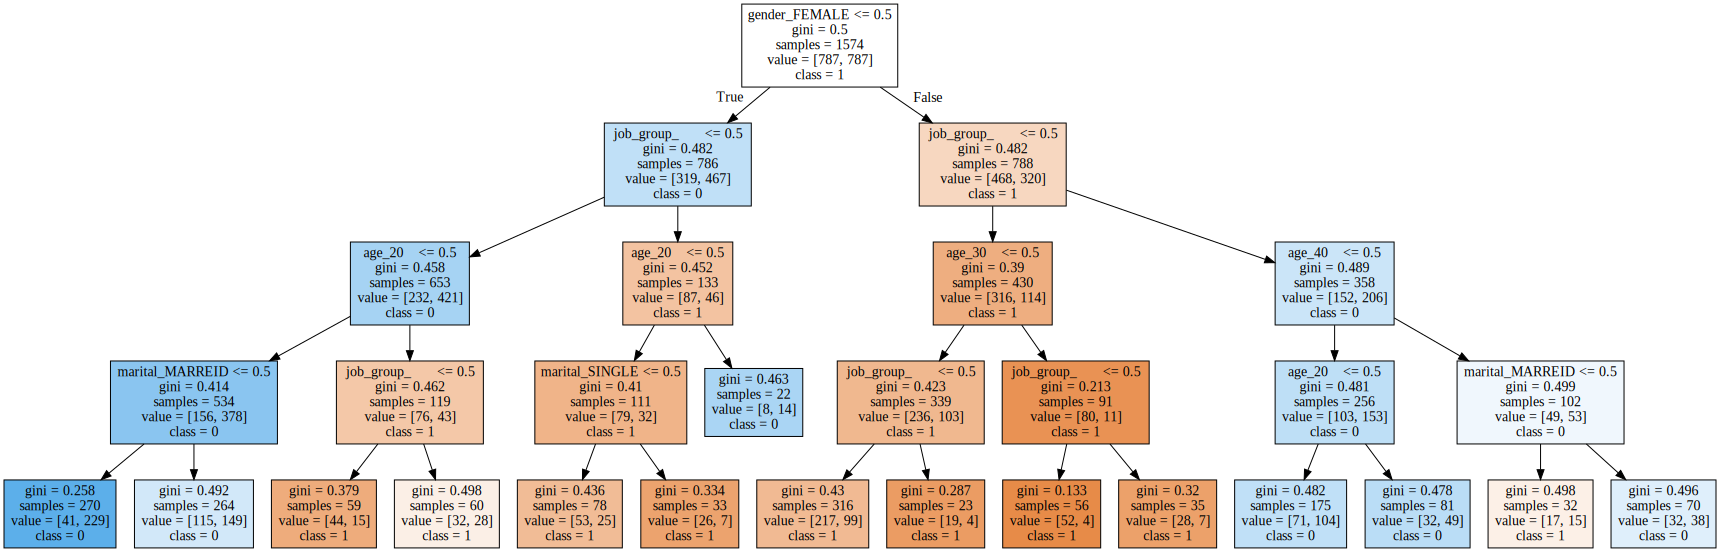

In [59]:
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf=19, min_samples_split=2, random_state=777)
tree.fit(dfh_train_x, dfh_train_y)
tree.score(dfh_test_x, dfh_test_y)
export_graphviz(tree, out_file='dfh_.dot', class_names=list(map(str, dfh_train_y.unique())), feature_names = dfh_train_x.columns, impurity = True, filled = True)
with open('dfh_.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [60]:
tmp = pd.concat([df_list[0], df_list[1], df_list[2],df_list[3],df_list[4],df_list[5],df_list[7],])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp['choice1'] = 0

In [61]:
dfg = df_list[6].copy()
dfg['choice1'] = 1

tmp = tmp[:len(dfg)]

dfg_train, dfg_test, tmp_train, tmp_test = train_test_split(dfg, tmp, test_size = 0.3)
dfg_train = pd.concat([dfg_train, tmp_train])
dfg_test = pd.concat([dfg_test, tmp_test])

dfg_train_x = dfg_train.drop('choice1', axis = 1, inplace = False)
dfg_test_x = dfg_test.drop('choice1', axis = 1, inplace = False)
dfg_train_y = dfg_train['choice1']
dfg_test_y = dfg_test['choice1']

dfg_train_x = pd.get_dummies(dfg_train_x)
dfg_test_x = pd.get_dummies(dfg_test_x)

# dfg = df_list[7].copy()
# dfg['choice1'] = 1
# try: tmp = tmp.loc[:len(dfg.index)-1, :]
# except: tmp = tmp.loc[:len(dfg.index)-1, :]
    
# dfg = pd.concat([dfg, tmp])

# df_x = pd.get_dummies(dfg.loc[:, ['gender', 'age', 'marital']])
# df_y = dfg[['choice1']]
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(dfg_train_x, dfg_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')
print(classification_report(dfg_test_y, grid_dt.predict(dfg_test_x)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
best parameter:
{'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 2}
best score:
0.636
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       309
           1       0.67      0.69      0.68       309

   micro avg       0.68      0.68      0.68       618
   macro avg       0.68      0.68      0.68       618
weighted avg       0.68      0.68      0.68       618



In [62]:
confusion_matrix(dfg_test_y, grid_dt.predict(dfg_test_x))

array([[205, 104],
       [ 96, 213]])

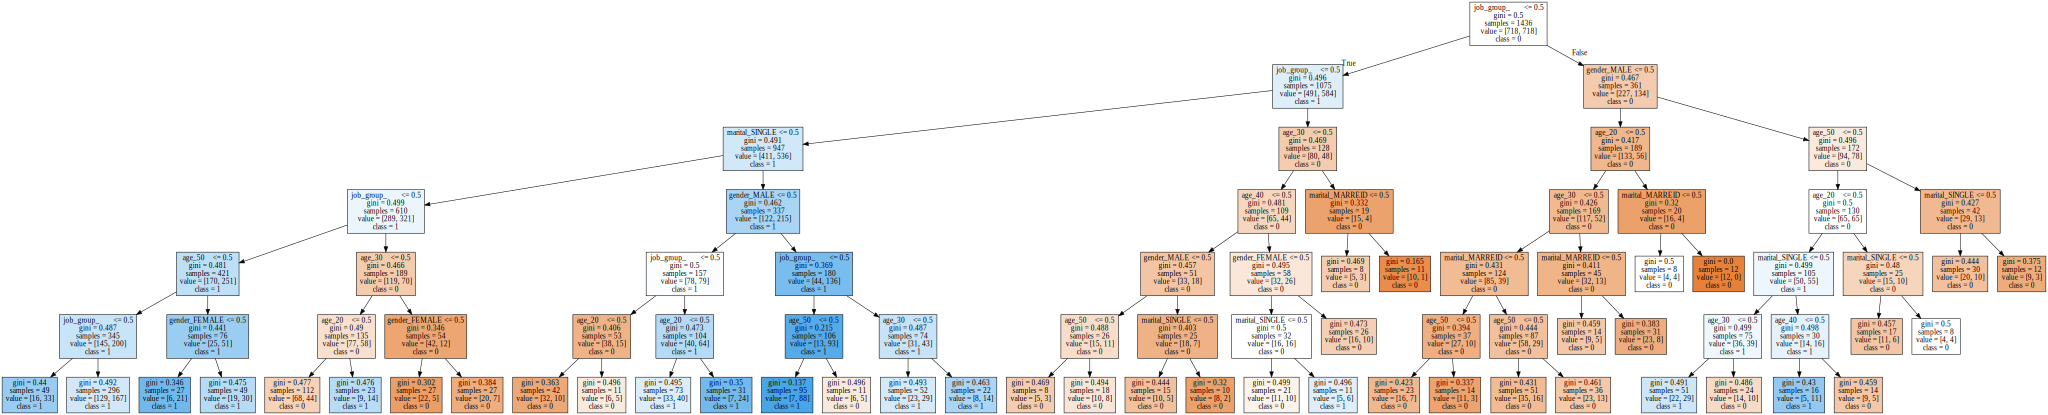

In [65]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=7, min_samples_split=2, random_state=777)
tree.fit(dfg_train_x, dfg_train_y)
tree.score(dfg_test_x, dfg_test_y)
export_graphviz(tree, out_file='dfg_.dot', class_names=('0', '1'), feature_names = dfg_train_x.columns, impurity = True, filled = True)
with open('dfg_.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [30]:
len(data[data['choice1'] == 'H'])

1125

In [78]:
tmp = pd.concat([df_list[0], df_list[5],df_list[3],df_list[4],df_list[2],df_list[6], df_list[7],])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp['choice1'] = 0

In [79]:
dfb = df_list[1].copy()
dfb['choice1'] = 1
dfb.drop('job_group', axis =1, inplace = True)

In [81]:
tmp.drop('job_group', axis = 1, inplace = True)

In [82]:


tmp = tmp[:len(dfb)]

dfb_train, dfb_test, tmp_train, tmp_test = train_test_split(dfb, tmp, test_size = 0.3)
dfb_train = pd.concat([dfb_train, tmp_train])
dfb_test = pd.concat([dfb_test, tmp_test])

dfb_train_x = dfb_train.drop('choice1', axis = 1, inplace = False)
dfb_test_x = dfb_test.drop('choice1', axis = 1, inplace = False)
dfb_train_y = dfb_train['choice1']
dfb_test_y = dfb_test['choice1']

dfb_train_x = pd.get_dummies(dfb_train_x)
dfb_test_x = pd.get_dummies(dfb_test_x)

# dfb = df_list[7].copy()
# dfb['choice1'] = 1
# try: tmp = tmp.loc[:len(dfb.index)-1, :]
# except: tmp = tmp.loc[:len(dfb.index)-1, :]
    
# dfb = pd.concat([dfb, tmp])

# df_x = pd.get_dummies(dfb.loc[:, ['gender', 'age', 'marital']])
# df_y = dfb[['choice1']]
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(dfb_train_x, dfb_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')
print(classification_report(dfb_test_y, grid_dt.predict(dfb_test_x)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
best parameter:
{'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 2}
best score:
0.64
              precision    recall  f1-score   support

           0       0.59      0.81      0.69       440
           1       0.70      0.45      0.55       440

   micro avg       0.63      0.63      0.63       880
   macro avg       0.65      0.63      0.62       880
weighted avg       0.65      0.63      0.62       880



In [83]:
confusion_matrix(dfb_test_y, grid_dt.predict(dfb_test_x))

array([[357,  83],
       [243, 197]])

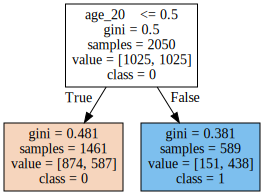

In [84]:
tree = DecisionTreeClassifier(max_depth=1, min_samples_leaf=5, min_samples_split=2, random_state=777)
tree.fit(dfb_train_x, dfb_train_y)
tree.score(dfb_test_x, dfb_test_y)
export_graphviz(tree, out_file='dfb_.dot', class_names=('0', '1'), feature_names = dfb_train_x.columns, impurity = True, filled = True)
with open('dfb_.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [87]:
tmp = pd.concat([df_list[0], df_list[1],df_list[3],df_list[4],df_list[6],df_list[5], df_list[7],])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp['choice1'] = 0

In [88]:
dfc = df_list[2].copy()
dfc['choice1'] = 1


tmp = tmp[:len(dfc)]

dfc_train, dfc_test, tmp_train, tmp_test = train_test_split(dfc, tmp, test_size = 0.3)
dfc_train = pd.concat([dfc_train, tmp_train])
dfc_test = pd.concat([dfc_test, tmp_test])

dfc_train_x = dfc_train.drop('choice1', axis = 1, inplace = False)
dfc_test_x = dfc_test.drop('choice1', axis = 1, inplace = False)
dfc_train_y = dfc_train['choice1']
dfc_test_y = dfc_test['choice1']

dfc_train_x = pd.get_dummies(dfc_train_x)
dfc_test_x = pd.get_dummies(dfc_test_x)

# dfc = df_list[7].copy()
# dfc['choice1'] = 1
# try: tmp = tmp.loc[:len(dfc.index)-1, :]
# except: tmp = tmp.loc[:len(dfc.index)-1, :]
    
# dfc = pd.concat([dfc, tmp])

# df_x = pd.get_dummies(dfc.loc[:, ['gender', 'age', 'marital']])
# df_y = dfc[['choice1']]
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(dfc_train_x, dfc_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')
print(classification_report(dfc_test_y, grid_dt.predict(dfc_test_x)))   

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
best parameter:
{'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 2}
best score:
0.727
              precision    recall  f1-score   support

           0       0.65      0.87      0.74       349
           1       0.80      0.53      0.63       349

   micro avg       0.70      0.70      0.70       698
   macro avg       0.72      0.70      0.69       698
weighted avg       0.72      0.70      0.69       698



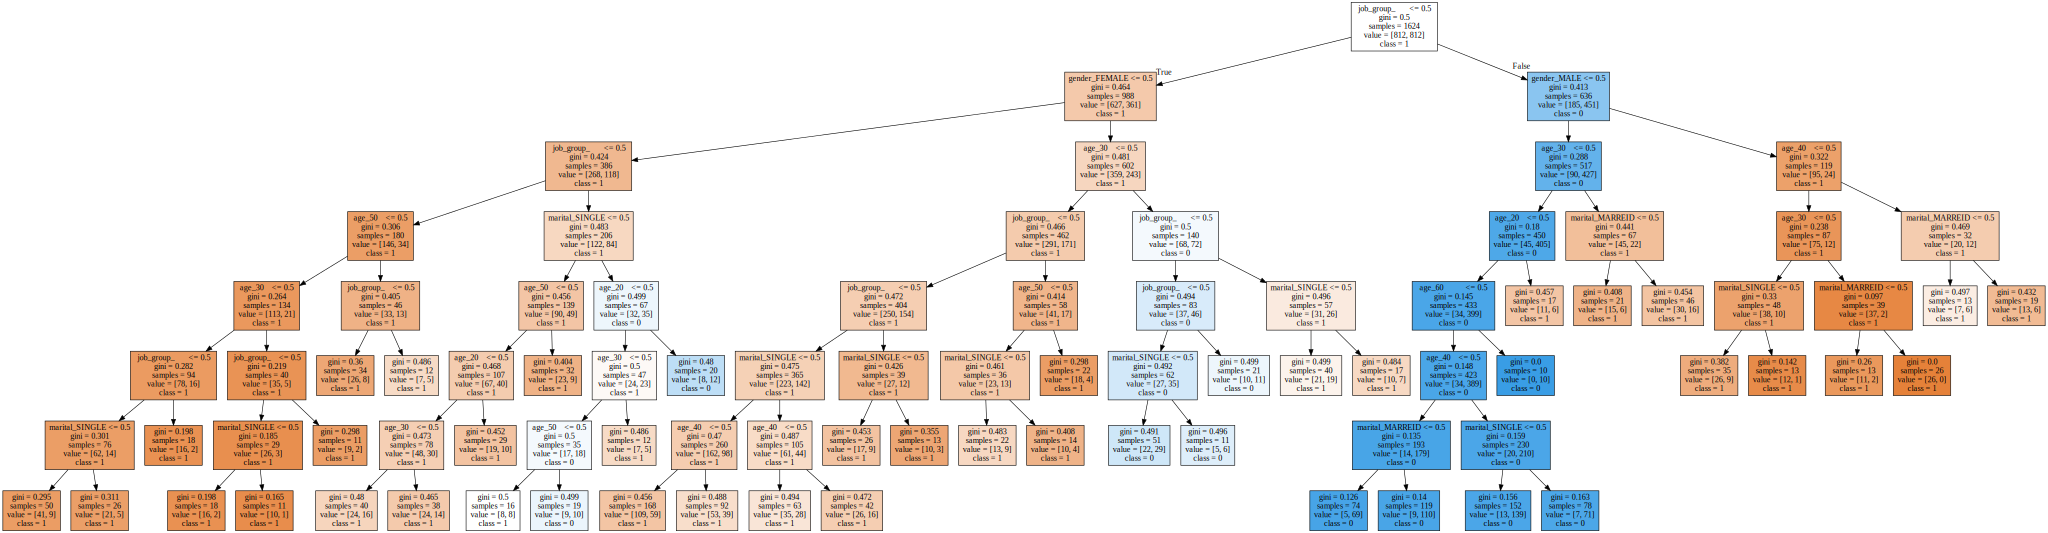

In [94]:
tree = DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, min_samples_split=2, random_state=777)
tree.fit(dfc_train_x, dfc_train_y)
tree.score(dfc_test_x, dfc_test_y)
export_graphviz(tree, out_file='dfc_.dot', class_names=list(map(str, dfc_test_y.unique())), feature_names = dfc_train_x.columns, impurity = True, filled = True)
with open('dfc_.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [95]:
tmp = pd.concat([df_list[0], df_list[1],df_list[2],df_list[4],df_list[6],df_list[5], df_list[7],])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp['choice1'] = 0

In [96]:
dfd = df_list[3].copy()
dfd['choice1'] = 1


tmp = tmp[:len(dfd)]

dfd_train, dfd_test, tmp_train, tmp_test = train_test_split(dfd, tmp, test_size = 0.3)
dfd_train = pd.concat([dfd_train, tmp_train])
dfd_test = pd.concat([dfd_test, tmp_test])

dfd_train_x = dfd_train.drop('choice1', axis = 1, inplace = False)
dfd_test_x = dfd_test.drop('choice1', axis = 1, inplace = False)
dfd_train_y = dfd_train['choice1']
dfd_test_y = dfd_test['choice1']

dfd_train_x = pd.get_dummies(dfd_train_x)
dfd_test_x = pd.get_dummies(dfd_test_x)

# dfd = df_list[7].copy()
# dfd['choice1'] = 1
# try: tmp = tmp.loc[:len(dfd.index)-1, :]
# except: tmp = tmp.loc[:len(dfd.index)-1, :]
    
# dfd = pd.concat([dfd, tmp])

# df_x = pd.get_dummies(dfd.loc[:, ['gender', 'age', 'marital']])
# df_y = dfd[['choice1']]
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(dfd_train_x, dfd_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')
print(classification_report(dfd_test_y, grid_dt.predict(dfd_test_x)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
best parameter:
{'max_depth': 6, 'min_samples_leaf': 9, 'min_samples_split': 2}
best score:
0.684
              precision    recall  f1-score   support

           0       0.64      0.76      0.70       561
           1       0.71      0.58      0.64       561

   micro avg       0.67      0.67      0.67      1122
   macro avg       0.68      0.67      0.67      1122
weighted avg       0.68      0.67      0.67      1122



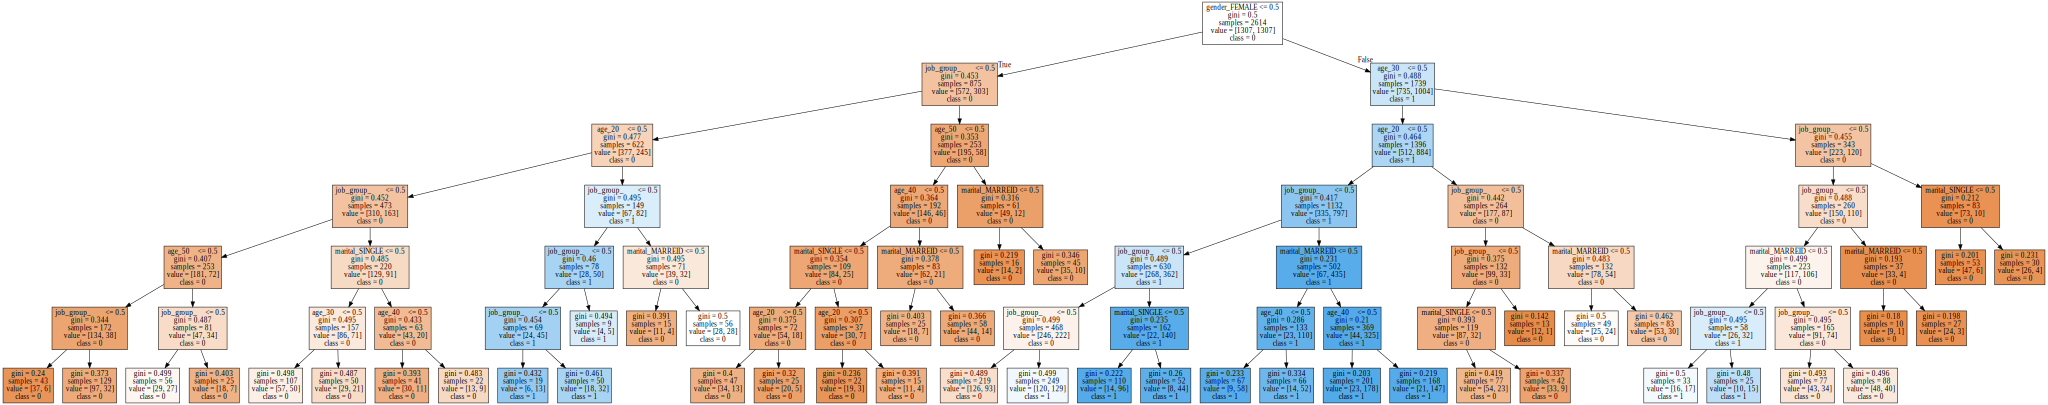

In [99]:
tree = DecisionTreeClassifier(max_depth=6, min_samples_leaf=9, min_samples_split=2, random_state=777)
tree.fit(dfd_train_x, dfd_train_y)
tree.score(dfd_test_x, dfd_test_y)
export_graphviz(tree, out_file='dfd_.dot', class_names=('0', '1'), feature_names = dfd_train_x.columns, impurity = True, filled = True)
with open('dfd_.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

age_20대  age_30대  age_40대  age_50대  age_60대 이상  gender_FEMALE  \
295         1        0        0        0           0              1   
499         1        0        0        0           0              1   
755         0        0        0        1           0              0   
1966        0        0        1        0           0              1   
2208        0        0        0        1           0              0   
2576        0        1        0        0           0              0   
9364        0        1        0        0           0              1   
617         0        1        0        0           0              1   
1351        0        0        1        0           0              1   
22          0        0        0        1           0              0   
308         0        1        0        0           0              1   
6722        0        0        1        0           0              0   
3161        0        1        0        0           0              0   
714         0        0        0        1           0              1   
772         0        0        0        1           0              0   
6832        1        0        0        0           0              0   
1755        0        1        0        0           0              1   
1311        0        0        0        1           0              0   
8208        0        1        0        0           0              1   
1765        0        1        0        0           0              0   
1404        1        0        0        0           0              1   
2191        1        0        0        0           0              1   
582         0        1        0        0           0              1   
2614        0        1        0        0           0              1   
3059        0        1        0        0           0              0   
1998        1        0        0        0           0              1   
2406        0        1        0        0           0              0   
141         0        0        0        1           0              0   
7922        0        0        1        0           0              1   
9964        1        0        0        0           0              1   
...       ...      ...      ...      ...         ...            ...   
1589        0        0        0        1           0              1   
324         0        1        0        0           0              1   
1252        0        1        0        0           0              1   
759         0        0        0        1           0              1   
1261        1        0        0        0           0              1   
5080        0        0        0        1           0              0   
2226        1        0        0        0           0              1   
5850        0        0        0        1           0              1   
9860        0        1        0        0           0              1   
1596        0        0        0        1           0              0   
1535        0        0        1        0           0              1   
1564        0        1        0        0           0              0   
1014        0        0        1        0           0              1   
2023        0        0        1        0           0              0   
1287        0        1        0        0           0              1   
758         0        0        0        1           0              0   
179         0        1        0        0           0              1   
1091        0        0        0        1           0              1   
834         0        0        0        1           0              0   
8068        0        0        0        1           0              1   
1229        0        0        0        1           0              1   
4950        0        1        0        0           0              0   
5945        0        0        0        1           0              1   
639         0        1        0        0           0              1   
1076        1        0        

In [108]:
tmp = pd.concat([df_list[0], df_list[1],df_list[3],df_list[2],df_list[6],df_list[5], df_list[7],])
tmp = tmp.sample(frac=1).reset_index(drop=True)
tmp['choice1'] = 0

In [109]:
dfe = df_list[3].copy()
dfe['choice1'] = 1

dfe.drop('job_group', axis = 1, inplace = True)
tmp.drop('job_group', axis = 1, inplace = True)

tmp = tmp[:len(dfe)]

dfe_train, dfe_test, tmp_train, tmp_test = train_test_split(dfe, tmp, test_size = 0.3)
dfe_train = pd.concat([dfe_train, tmp_train])
dfe_test = pd.concat([dfe_test, tmp_test])

dfe_train_x = dfe_train.drop('choice1', axis = 1, inplace = False)
dfe_test_x = dfe_test.drop('choice1', axis = 1, inplace = False)
dfe_train_y = dfe_train['choice1']
dfe_test_y = dfe_test['choice1']

dfe_train_x = pd.get_dummies(dfe_train_x)
dfe_test_x = pd.get_dummies(dfe_test_x)

# dfe = df_list[7].copy()
# dfe['choice1'] = 1
# try: tmp = tmp.loc[:len(dfe.index)-1, :]
# except: tmp = tmp.loc[:len(dfe.index)-1, :]
    
# dfe = pd.concat([dfe, tmp])

# df_x = pd.get_dummies(dfe.loc[:, ['gender', 'age', 'marital']])
# df_y = dfe[['choice1']]
# df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size = 0.3)

estimator = DecisionTreeClassifier()

para_depth = [depth for depth in range(1, 16)]
para_split = [split * 2 for split in range(1, 11)]
para_leaf = [leaf for leaf in range(5, 30)]

param_grid = {'max_depth':para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = 'accuracy', n_jobs = -1)
grid_dt.fit(dfe_train_x, dfe_train_y)

print(f'best model:\n{grid_dt.best_estimator_}')
print(f'best parameter:\n{grid_dt.best_params_}')
print(f'best score:\n{grid_dt.best_score_.round(3)}')
print(classification_report(dfe_test_y, grid_dt.predict(dfe_test_x)))

/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
best parameter:
{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
best score:
0.622
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       561
           1       0.61      0.61      0.61       561

   micro avg       0.61      0.61      0.61      1122
   macro avg       0.61      0.61      0.61      1122
weighted avg       0.61      0.61      0.61      1122



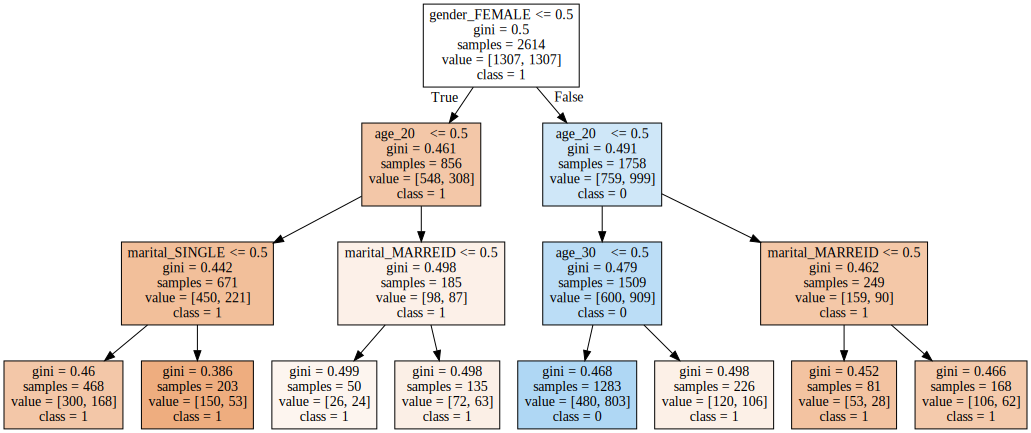

In [111]:
tree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, min_samples_split=2, random_state=777)
tree.fit(dfe_train_x, dfe_train_y)
tree.score(dfe_test_x, dfe_test_y)
export_graphviz(tree, out_file='dfe_.dot', class_names=('1', '0'), feature_names = dfe_train_x.columns, impurity = True, filled = True)
with open('dfe_.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [113]:
dfe_test_x.head()

gender_FEMALE  gender_MALE  age_20대  age_30대  age_40대  age_50대  \
4586              1            0        0        0        0        1   
6783              1            0        0        0        1        0   
5731              0            1        0        1        0        0   
6812              1            0        0        1        0        0   
4863              1            0        0        0        1        0   

      age_60대 이상  marital_MARREID  marital_SINGLE  
4586           0                0               1  
6783           0                0               1  
5731           0                1               0  
6812           0                1               0  
4863           0                0               1

In [172]:
tmp

gender     age  marital job_group  choice1
0      MALE     50대   SINGLE        프리        0
1    FEMALE     20대  MARREID        프리        0
2    FEMALE     50대  MARREID        고급        0
3    FEMALE     40대  MARREID        프리        0
4      MALE     20대  MARREID        프리        0
5    FEMALE     20대   SINGLE        프리        0
6    FEMALE     40대  MARREID        프리        0
7    FEMALE     30대  MARREID        고급        0
8    FEMALE     50대   SINGLE        고급        0
9      MALE     40대  MARREID        중급        0
10   FEMALE     40대  MARREID        중급        0
11     MALE     50대  MARREID        중급        0
12   FEMALE     20대   SINGLE        프리        0
13     MALE     40대  MARREID        중급        0
14   FEMALE     20대   SINGLE        프리        0
15     MALE     40대   SINGLE        중급        0
16   FEMALE     20대   SINGLE        프리        0
17     MALE     40대  MARREID         갓        0
18     MALE     50대   SINGLE        중급        0
19     MALE     40대  MARREID         갓        0
20   FEMALE     20대  MARREID        중급        0
21   FEMALE     50대  MARREID        고급        0
22   FEMALE     20대  MARREID        학생        0
23     MALE     20대  MARREID        프리        0
24   FEMALE     40대  MARREID        고급        0
25     MALE     40대   SINGLE        프리        0
26     MALE     40대   SINGLE        프리        0
27     MALE     50대  MARREID        고급        0
28     MALE     30대   SINGLE        중급        0
29     MALE     50대  MARREID        중급        0
..      ...     ...      ...       ...      ...
792    MALE     20대  MARREID        학생        0
793  FEMALE     40대  MARREID        중급        0
794  FEMALE     50대  MARREID        중급        0
795    MALE     50대   SINGLE        프리        0
796  FEMALE     40대  MARREID        프리        0
797    MALE     40대  MARREID        프리        0
798    MALE     20대  MARREID        중급        0
799  FEMALE  60대 이상  MARREID        고급        0
800    MALE     40대   SINGLE         갓        0
801    MALE     30대  MARREID         갓        0
802  FEMALE     40대  MARREID        중급        0
803  FEMALE     20대   SINGLE        프리        0
804    MALE     50대   SINGLE        중급        0
805  FEMALE     50대   SINGLE        중급        0
806    MALE     30대  MARREID         갓        0
807    MALE     40대  MARREID        중급        0
808  FEMALE     30대   SINGLE        고급        0
809    MALE     30대   SINGLE        프리        0
810  FEMALE     20대   SINGLE        프리        0
811  FEMALE     30대  MARREID        중급        0
812  FEMALE     40대   SINGLE        중급        0
813  FEMALE     50대  MARREID        중급        0
814    MALE     40대  MARREID        프리        0
815  FEMALE     20대  MARREID        프리        0
816  FEMALE     30대   SINGLE        중급        0
817  FEMALE     40대   SINGLE        중급        0
818    MALE     30대  MARREID        중급        0
819    MALE     20대   SINGLE        프리        0
820  FEMALE     50대   SINGLE        고급        0
821  FEMALE     50대  MARREID         갓        0

[822 rows x 5 columns]

In [176]:
tmp = pd.concat(df_list[1:])
tmp = tmp.sample(frac=1).reset_index(drop=True)


gender  age  marital job_group choice1
0    MALE  20대  MARREID        고급       B
1    MALE  20대   SINGLE        프리       F
2    MALE  40대  MARREID        중급       G
3  FEMALE  40대  MARREID         갓       D
4  FEMALE  30대   SINGLE        고급       E

gender  age  marital job_group choice1
817  FEMALE  40대  MARREID         갓       D
818  FEMALE  20대   SINGLE        학생       B
819    MALE  20대   SINGLE        프리       E
820  FEMALE  40대  MARREID        중급       H
821  FEMALE  30대   SINGLE        프리       D

In [207]:
a[a['choice1'] != 1]

gender     age  marital job_group choice1
0      MALE     40대  MARREID        고급       F
1      MALE     30대  MARREID        고급       E
2    FEMALE     40대   SINGLE        고급       C
3    FEMALE     40대  MARREID        고급       C
4    FEMALE     50대  MARREID        고급       C
5      MALE     30대  MARREID        중급       E
6    FEMALE     40대  MARREID        프리       G
7    FEMALE     40대  MARREID        고급       D
8    FEMALE     20대   SINGLE        프리       B
9    FEMALE     20대  MARREID        프리       E
10     MALE     30대   SINGLE        고급       G
11   FEMALE     40대   SINGLE        프리       B
12   FEMALE     40대  MARREID        고급       C
13     MALE     20대   SINGLE        중급       F
14     MALE     30대   SINGLE        중급       H
15     MALE     30대  MARREID         갓       E
16   FEMALE     40대   SINGLE        중급       C
17     MALE     40대  MARREID         갓       F
18     MALE     40대   SINGLE        중급       D
19   FEMALE     40대  MARREID        고급       G
20     MALE     40대  MARREID        고급       F
21   FEMALE     40대  MARREID        중급       D
22     MALE     30대  MARREID        프리       E
23   FEMALE     30대   SINGLE        프리       C
24   FEMALE     40대  MARREID        프리       G
25     MALE     20대   SINGLE        프리       E
26   FEMALE     50대   SINGLE        프리       F
27   FEMALE     50대  MARREID        고급       G
28     MALE     40대  MARREID        프리       D
29   FEMALE     50대  MARREID        프리       E
..      ...     ...      ...       ...     ...
792  FEMALE     20대  MARREID        프리       B
793  FEMALE     50대  MARREID         갓       C
794  FEMALE     30대   SINGLE        고급       C
795  FEMALE     30대  MARREID         갓       E
796    MALE     30대   SINGLE        고급       G
797    MALE     40대  MARREID        프리       E
798    MALE     50대  MARREID        중급       B
799    MALE     20대  MARREID        프리       B
800  FEMALE     50대  MARREID        프리       H
801  FEMALE     20대   SINGLE        중급       B
802  FEMALE     40대  MARREID        프리       H
803  FEMALE     50대  MARREID         갓       D
804  FEMALE     30대  MARREID        중급       B
805    MALE     40대  MARREID        프리       H
806  FEMALE     40대  MARREID        고급       C
807  FEMALE     40대   SINGLE        중급       D
808  FEMALE     50대   SINGLE         갓       B
809  FEMALE  60대 이상   SINGLE        고급       C
810  FEMALE     40대  MARREID        중급       E
811  FEMALE     20대   SINGLE        프리       D
812  FEMALE     20대  MARREID        프리       E
813  FEMALE     40대  MARREID        프리       D
814  FEMALE     40대  MARREID        고급       D
815    MALE     40대  MARREID        프리       D
816  FEMALE     40대   SINGLE        중급       D
817    MALE     30대  MARREID        고급       E
818  FEMALE     20대  MARREID        프리       H
819  FEMALE     20대  MARREID        프리       H
820  FEMALE     30대  MARREID        고급       D
821  FEMALE     40대   SINGLE        고급       C

[822 rows x 5 columns]

In [209]:
dfa.head()

tmp = pd.concat(df_list[1:])
tmp = tmp.sample(frac=1).reset_index(drop=True)[:len(dfa)]
tmp['choice1'] = 0

a = pd.concat([dfa, tmp])

a.to_csv('train_a.csv', index = False)

In [210]:
dfb.head()

tmp = pd.concat(df_list[2:])
tmp = pd.concat([tmp, df_list[0]])
tmp = tmp.sample(frac=1).reset_index(drop=True)[:len(dfb)]
tmp['choice1'] = 0

b = pd.concat([dfb, tmp])
b.to_csv('train_b.csv', index = False)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [211]:
dfc.head()

tmp = pd.concat(df_list[:2])
tmp1 = pd.concat(df_list[3:])
tmp = pd.concat([tmp, tmp1])
tmp = tmp.sample(frac=1).reset_index(drop=True)[:len(dfc)]
tmp['choice1'] = 0

c = pd.concat([dfc, tmp])
c.to_csv('train_c.csv', index = False)

In [212]:
dfd.head()

tmp = pd.concat(df_list[:3])
tmp1 = pd.concat(df_list[4:])
tmp = pd.concat([tmp, tmp1])
tmp = tmp.sample(frac=1).reset_index(drop=True)[:len(dfd)]
tmp['choice1'] = 0
d = pd.concat([dfd, tmp])
d.to_csv('train_d.csv', index = False)

In [213]:
dfe.head()

tmp = pd.concat(df_list[:4])
tmp1 = pd.concat(df_list[5:])
tmp = pd.concat([tmp, tmp1])
tmp = tmp.sample(frac=1).reset_index(drop=True)[:len(dfe)]
tmp['choice1'] = 0
e = pd.concat([dfe, tmp])
e.to_csv('train_e.csv', index = False)

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [200]:
tree.predict(np.array([0,1,1,0,0,0,0,0,1,0,0,1,0,0,]).reshape(1,-1))

array([1])

In [195]:
dff_train_x.head()

gender_FEMALE  gender_MALE  age_20대  age_30대  age_40대  age_50대  \
4369              0            1        1        0        0        0   
1712              0            1        0        0        1        0   
250               0            1        0        0        0        1   
542               0            1        0        0        1        0   
1799              1            0        0        0        0        1   

      age_60대 이상  marital_MARREID  marital_SINGLE  job_group_갓  job_group_고급  \
4369           0                0               1            0             0   
1712           0                1               0            0             1   
250            0                0               1            0             0   
542            0                1               0            0             0   
1799           0                1               0            0             0   

      job_group_중급  job_group_프리  job_group_학생  
4369             1             0             0  
1712             0             0             0  
250              1             0             0  
542              1             0             0  
1799             1             0             0

In [214]:
dff.head()

tmp = pd.concat(df_list[:5])
tmp1 = pd.concat(df_list[6:])
tmp = pd.concat([tmp, tmp1])
tmp = tmp.sample(frac=1).reset_index(drop=True)[:len(dff)]
tmp['choice1'] = 0
f = pd.concat([dff, tmp])
f.to_csv('train_f.csv', index = False)

In [215]:
dfg.head()

tmp = pd.concat(df_list[:6])
tmp = pd.concat([tmp, df_list[7]])
tmp = tmp.sample(frac=1).reset_index(drop=True)[:len(dfg)]
tmp['choice1'] = 0
g = pd.concat([dfg, tmp])
g.to_csv('train_g.csv', index = False)

In [216]:
dfh.head()

tmp = pd.concat(df_list[:7])
tmp = tmp.sample(frac=1).reset_index(drop=True)[:len(dfh)]
tmp['choice1'] = 0
h = pd.concat([dfh, tmp])
h.to_csv('train_h.csv', index = False)

In [219]:
for group_idx, group in enumerate([['A', 'F', 'H', 'G'], ['B', 'C'], ['D', 'E']]):
    for idx in data.index:
        if data.loc[idx, 'choice1'][0] in group:
            data.loc[idx, 'choice_group'] = group_idx


In [223]:
data.groupby(['choice_group']).count()

gender   age  marital  job_group  choice1
choice_group                                           
0.0             3895  3895     3895       3895     3895
1.0             2626  2626     2626       2626     2626
2.0             3479  3479     3479       3479     3479

In [224]:
data.groupby(['gender']).count()

age  marital  job_group  choice1  choice_group
gender                                                 
FEMALE  5958     5958       5958     5958          5958
MALE    4042     4042       4042     4042          4042

In [227]:
data.groupby(['gender', 'age', 'choice_group']).count()

marital  job_group  choice1
gender age    choice_group                             
FEMALE 20대    0.0               374        374      374
              1.0               536        536      536
              2.0               240        240      240
       30대    0.0               308        308      308
              1.0               357        357      357
              2.0               827        827      827
       40대    0.0               458        458      458
              1.0               585        585      585
              2.0               696        696      696
       50대    0.0               350        350      350
              1.0               499        499      499
              2.0               676        676      676
       60대 이상 0.0                 7          7        7
              1.0                18         18       18
              2.0                27         27       27
MALE   20대    0.0               307        307      307
              1.0               235        235      235
              2.0               256        256      256
       30대    0.0               522        522      522
              1.0               114        114      114
              2.0               361        361      361
       40대    0.0               884        884      884
              1.0               133        133      133
              2.0               186        186      186
       50대    0.0               663        663      663
              1.0               141        141      141
              2.0               201        201      201
       60대 이상 0.0                22         22       22
              1.0                 8          8        8
              2.0                 9          9        9

In [240]:
data.groupby(['gender', 'age', 'choice_group']).count()

marital  job_group  choice1
gender age    choice_group                             
FEMALE 20대    0.0               374        374      374
              1.0               536        536      536
              2.0               240        240      240
       30대    0.0               308        308      308
              1.0               357        357      357
              2.0               827        827      827
       40대    0.0               458        458      458
              1.0               585        585      585
              2.0               696        696      696
       50대    0.0               350        350      350
              1.0               499        499      499
              2.0               676        676      676
       60대 이상 0.0                 7          7        7
              1.0                18         18       18
              2.0                27         27       27
MALE   20대    0.0               307        307      307
              1.0               235        235      235
              2.0               256        256      256
       30대    0.0               522        522      522
              1.0               114        114      114
              2.0               361        361      361
       40대    0.0               884        884      884
              1.0               133        133      133
              2.0               186        186      186
       50대    0.0               663        663      663
              1.0               141        141      141
              2.0               201        201      201
       60대 이상 0.0                22         22       22
              1.0                 8          8        8
              2.0                 9          9        9

In [231]:
data.groupby(['gender', 'age', 'job_group', 'choice1']).count()

marital  choice_group
gender age    job_group choice1                       
FEMALE 20대    갓         A              4             4
                        B             44            44
                        C              5             5
                        D              3             3
                        E              4             4
                        F              5             5
                        G              4             4
                        H              2             2
              고급        A             10            10
                        B             13            13
                        C              8             8
                        D             10            10
                        E             15            15
                        F             12            12
                        G             19            19
                        H             14            14
              중급        A              9             9
                        B            154           154
                        C             29            29
                        D             14            14
                        E             13            13
                        F              8             8
                        G              6             6
                        H             11            11
              프리        A             37            37
                        B             70            70
                        C             33            33
                        D             76            76
                        E             69            69
                        F             33            33
                        G             90            90
                        H             77            77
              학생        A             10            10
                        B            162           162
                        C             18            18
                        D             18            18
                        E             18            18
                        F              7             7
                        G             11            11
                        H              5             5
       30대    갓         A              6             6
                        B             21            21
                        C             17            17
                        D              5             5
                        E            104           104
                        F              4             4
                        G              2             2
                        H              3             3
              고급        A             11            11
                        B             54            54
                        C             36            36
                        D             65            65
                        E            225           225
                        F             10            10
                        G             18            18
                        H              9             9
              중급        A              4             4
                        B             75            75
                        C             48            48
                        D             19            19
                        E            280           280
                        F             16            16
                        G             22            22
                        H              7             7
              프리        A             33            33
                        B             73            73
                        C             33            33
                        D             70            70
                        E             59            59
                        F             32            32
                        G             57            57
                  

In [230]:
pd.options.display.max_rows=None

In [233]:
data[data['choice1'] == 'C'].groupby(['gender', 'age', 'job_group'])['age'].count()

gender  age     job_group
FEMALE  20대     갓              5
                고급             8
                중급            29
                프리            33
                학생            18
        30대     갓             17
                고급            36
                중급            48
                프리            33
        40대     갓             10
                고급           297
                중급            47
                프리            37
        50대     갓              6
                고급           250
                중급            18
                프리            54
        60대 이상  고급            11
                프리             1
MALE    20대     갓              3
                고급             3
                중급             4
                프리            29
                학생             4
        30대     갓              6
                고급             6
                중급             6
                프리            22
        40대     갓              4
                고

In [234]:
data[data['choice1'] == 'D'].groupby(['gender', 'age', 'job_group'])['age'].count()

gender  age     job_group
FEMALE  20대     갓              3
                고급            10
                중급            14
                프리            76
                학생            18
        30대     갓              5
                고급            65
                중급            19
                프리            70
        40대     갓            102
                고급           100
                중급           274
                프리            77
        50대     갓             99
                고급            69
                중급           337
                프리            64
        60대 이상  갓              4
                고급             2
                중급            13
                프리             2
MALE    20대     갓              6
                고급            14
                중급            11
                프리            52
                학생            48
        30대     갓              7
                고급            19
                중급            18
                프

In [235]:
data.groupby(['choice1']).count()

gender   age  marital  job_group  choice_group
choice1                                                
A           822   822      822        822           822
B          1465  1465     1465       1465          1465
C          1161  1161     1161       1161          1161
D          1868  1868     1868       1868          1868
E          1611  1611     1611       1611          1611
F           921   921      921        921           921
G          1027  1027     1027       1027          1027
H          1125  1125     1125       1125          1125

In [237]:
data.groupby(['age', 'choice_group']).count()

gender  marital  job_group  choice1
age    choice_group                                     
20대    0.0              681      681        681      681
       1.0              771      771        771      771
       2.0              496      496        496      496
30대    0.0              830      830        830      830
       1.0              471      471        471      471
       2.0             1188     1188       1188     1188
40대    0.0             1342     1342       1342     1342
       1.0              718      718        718      718
       2.0              882      882        882      882
50대    0.0             1013     1013       1013     1013
       1.0              640      640        640      640
       2.0              877      877        877      877
60대 이상 0.0               29       29         29       29
       1.0               26       26         26       26
       2.0               36       36         36       36

In [238]:
data.groupby('age').count()

gender  marital  job_group  choice1  choice_group
age                                                      
20대       1948     1948       1948     1948          1948
30대       2489     2489       2489     2489          2489
40대       2942     2942       2942     2942          2942
50대       2530     2530       2530     2530          2530
60대 이상      91       91         91       91            91